In [1]:
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import LabelEncoder
import glob

In [2]:
def load_data(file_name, dataset):
    """
    Load the data from a Parquet file, encode the target variable, and split the data into training and validation sets.

    Parameters:
    - file_name (str): Name of the file to load (without '.parquet' extension and path).

    Returns:
    - X_train (DataFrame): Training features.
    - y_train (Series): Training labels.
    - X_val (DataFrame): Validation features.
    - y_val (Series): Validation labels.
    """
    data_path = f'../../../../data/features/{dataset}/{file_name}.parquet'
    data = pd.read_parquet(data_path)
    label_encoder = LabelEncoder()
    data["Label"] = label_encoder.fit_transform(data["Target"])

    X_train = data[data['Train'] == 0].drop(columns=["Target", "Train", "Label"])
    y_train = data[data['Train'] == 0]['Label']
    X_val = data[data['Train'] == 1].drop(columns=["Target", "Train", "Label"])
    y_val = data[data['Train'] == 1]['Label']

    return X_train, y_train, X_val, y_val

def evaluate_model(X_train, y_train, X_val, y_val, params, file_name):
    """
    Train a Random Forest model with the given parameters and evaluate it on both the training and validation sets.

    Parameters:
    - X_train (DataFrame): Training features.
    - y_train (Series): Training labels.
    - X_val (DataFrame): Validation features.
    - y_val (Series): Validation labels.
    - params (dict): Parameters for the Random Forest model.

    Returns:
    - result (dict): Dictionary containing the parameters and evaluation metrics for both training and validation sets.
    """
    print(f"Training Random Forest: {params}")
    rf = RandomForestClassifier(random_state=42, n_jobs=-1, **params)
    rf.fit(X_train, y_train)
    
    # Predictions for validation and training set
    y_pred_val = rf.predict(X_val)
    y_pred_train = rf.predict(X_train)

    # Evaluation metrics for validation set
    accuracy_val = accuracy_score(y_val, y_pred_val)
    macro_f1_val = f1_score(y_val, y_pred_val, average='macro')

    # Evaluation metrics for training set
    accuracy_train = accuracy_score(y_train, y_pred_train)
    macro_f1_train = f1_score(y_train, y_pred_train, average='macro')

    result = {
        'features': file_name,
        'max_depth': params.get('max_depth'),
        'criterion': params.get('criterion'),
        'class_weight': params.get('class_weight'),
        'accuracy_val': accuracy_val,
        'macro_f1_val': macro_f1_val,
        'accuracy_train': accuracy_train,
        'macro_f1_train': macro_f1_train
    }

    return result

def grid_search(X_train, y_train, X_val, y_val, param_grid, file_name):
    """
    Perform a grid search over the specified parameter grid for a Random Forest model and save the results.

    Parameters:
    - X_train (DataFrame): Training features.
    - y_train (Series): Training labels.
    - X_val (DataFrame): Validation features.
    - y_val (Series): Validation labels.
    - param_grid (dict): Grid of parameters to search over.
    - file_name (str): Base name for the output CSV file to store the results.
    """
    results = []

    for params in ParameterGrid(param_grid):
        result = evaluate_model(X_train, y_train, X_val, y_val, params, file_name)
        results.append(result)
        print(f"Params: {params}, Accuracy: {result['accuracy_val']}, Macro F1: {result['macro_f1_val']}")

    results_df = pd.DataFrame(results)
    return results_df

In [3]:
file_names = [os.path.splitext(os.path.basename(file))[0] for file in glob.glob("../../../../data/features/SARS/*.parquet")]
dataset = "SARS"

print(file_names)

file = file_names[5]

X_train, y_train, X_val, y_val = load_data(file, dataset)

param_grid = {
    'max_depth': list(range(1, 41)) + [None],
    'criterion': ['gini'],
    'class_weight': [None]
}

results_df = grid_search(X_train, y_train, X_val, y_val, param_grid, file)

['Mash_distance_remove_21', '7-mer_FFP_remove', 'ACS_remove', '7-mer_remove', 'FCGR_remove_256', 'DSP_replace_real', 'RTD_7-mer_remove', 'FCGR_remove_128', '7-spaced_remove']
Training Random Forest: {'class_weight': None, 'criterion': 'gini', 'max_depth': 1}
Params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 1}, Accuracy: 0.06299212598425197, Macro F1: 0.012935262960721164
Training Random Forest: {'class_weight': None, 'criterion': 'gini', 'max_depth': 2}
Params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 2}, Accuracy: 0.10310704405192594, Macro F1: 0.03248805592043319
Training Random Forest: {'class_weight': None, 'criterion': 'gini', 'max_depth': 3}
Params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 3}, Accuracy: 0.2294105128750798, Macro F1: 0.056985917706180805
Training Random Forest: {'class_weight': None, 'criterion': 'gini', 'max_depth': 4}
Params: {'class_weight': None, 'criterion': 'gini', 'max_depth': 4}, Accuracy: 0.24452011066184295

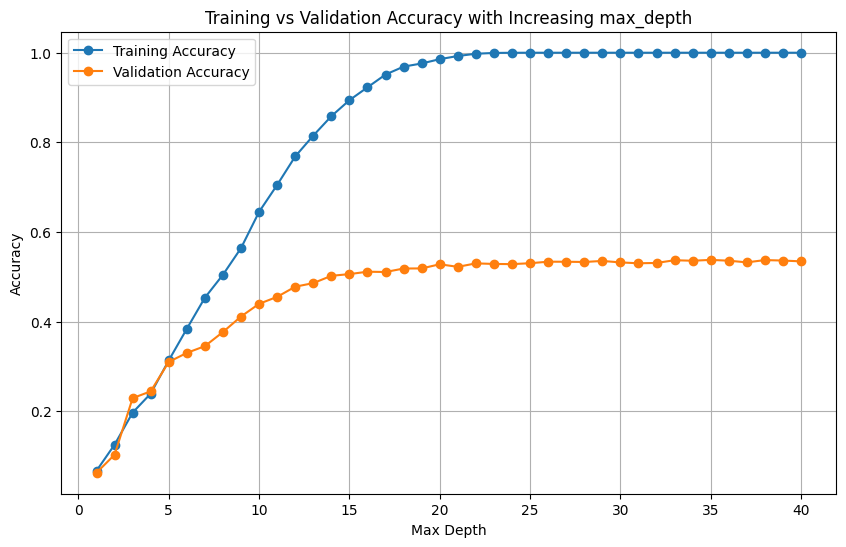

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results_df['max_depth'], results_df['accuracy_train'], label='Training Accuracy', marker='o')
plt.plot(results_df['max_depth'], results_df['accuracy_val'], label='Validation Accuracy', marker='o')

plt.title('Training vs Validation Accuracy with Increasing max_depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
